In [42]:
import os
import wget
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from shutil import copyfile
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import numpy as np

In [7]:
source_path = 'Source_data'

source_path_cats = os.path.join(source_path, 'Cats')
source_path_dogs = os.path.join(source_path, 'Dogs')

print(f'There are {len(os.listdir(source_path_cats))} images of cats')
print(f'There are {len(os.listdir(source_path_dogs))} images of dogs')

There are 1000 images of cats
There are 1000 images of dogs


In [11]:
root_dir = 'Root_data'

#define a function to create train & val directories

def create_train_val_dir(root_path):
    
    train_dir_path = os.path.join(root_path, 'training')
    os.makedirs(train_dir_path)

    validation_dir_path = os.path.join(root_path, 'validation')
    os.makedirs(validation_dir_path)


    train_cats_dir_path = os.path.join(train_dir_path, 'cats')
    os.makedirs(train_cats_dir_path)

    train_dogs_dir_path = os.path.join(train_dir_path, 'dogs')
    os.makedirs(train_dogs_dir_path)


    validation_cats_dir_path = os.path.join(validation_dir_path, 'cats')
    os.makedirs(validation_cats_dir_path)

    validation_dogs_dir_path = os.path.join(validation_dir_path, 'dogs')
    os.makedirs(validation_dogs_dir_path)

In [12]:
create_train_val_dir(root_dir)

In [13]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

Root_data\training
Root_data\validation
Root_data\training\cats
Root_data\training\dogs
Root_data\validation\cats
Root_data\validation\dogs


In [14]:
#define a function to split data into training & testing

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    
    total_images = os.listdir(SOURCE_DIR)
    total_images_cleaned = []
    
    # if image size is zero then ignore
    for image in total_images:
        path = os.path.join(SOURCE_DIR, image)
        if os.path.getsize(path) == 0:
            print(f'{image} is zero length. so ignoring')
        else:
            total_images_cleaned.append(image)
      
    #split the total images into training & validation
    training_size = int(len(total_images_cleaned) * SPLIT_SIZE)
    training_images = total_images_cleaned[:training_size]
    testing_images = total_images_cleaned[training_size:]
    
    
    #copy images into training & validation directories
    for image in training_images:
        src = os.path.join(SOURCE_DIR, image)
        dest = os.path.join(TRAINING_DIR, image)
        copyfile(src, dest)
        
    for image in testing_images:
        src = os.path.join(SOURCE_DIR, image)
        dest = os.path.join(VALIDATION_DIR, image)
        copyfile(src, dest)
        
        

In [15]:
# Define paths
CAT_SOURCE_DIR = source_path_cats
DOG_SOURCE_DIR = source_path_dogs

TRAINING_DIR = "Root_data/training"
VALIDATION_DIR = "Root_data/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

In [16]:
split_size = .9

split_data(CAT_SOURCE_DIR , TRAINING_CATS_DIR, VALIDATION_CATS_DIR , split_size)
split_data(DOG_SOURCE_DIR , TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR , split_size)

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

There are 900 images of cats for training
There are 900 images of dogs for training
There are 100 images of cats for validation
There are 100 images of dogs for validation


In [19]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    
    #train generator using all arguments
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
    
    #val generator using only rescale
    validation_datagen = ImageDataGenerator(rescale = 1.0/255)
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    
    return train_generator, validation_generator
    


In [20]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [22]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False



87910968/87910968 [==============================] - 265s 3us/step


In [23]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [24]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [27]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(units = 1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units = 1, activation = 'sigmoid')(x)

model = Model(inputs = pre_trained_model.inputs, outputs = x)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [28]:
# Set the training parameters
model.compile(optimizer = 'RMSProp', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [30]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 2)

Epoch 1/5
57/57 - 79s - loss: 0.3242 - accuracy: 0.8889 - val_loss: 0.1483 - val_accuracy: 0.9550 - 79s/epoch - 1s/step
Epoch 2/5
57/57 - 82s - loss: 0.3036 - accuracy: 0.8933 - val_loss: 0.1758 - val_accuracy: 0.9550 - 82s/epoch - 1s/step
Epoch 3/5
57/57 - 84s - loss: 0.2395 - accuracy: 0.9156 - val_loss: 0.1520 - val_accuracy: 0.9550 - 84s/epoch - 1s/step
Epoch 4/5
57/57 - 115s - loss: 0.2694 - accuracy: 0.9106 - val_loss: 0.2146 - val_accuracy: 0.9350 - 115s/epoch - 2s/step
Epoch 5/5
57/57 - 113s - loss: 0.2374 - accuracy: 0.9194 - val_loss: 0.2138 - val_accuracy: 0.9500 - 113s/epoch - 2s/step


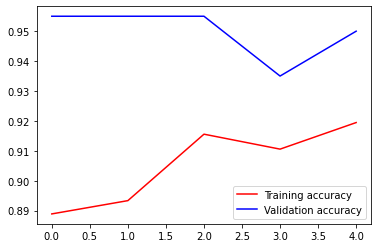

In [33]:
acc=  history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.legend()
plt.show()

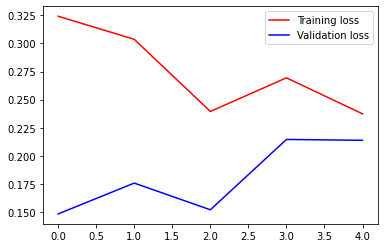

In [35]:
loss=  history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.legend()
plt.show()

In [45]:
def predict_image(image_path):
    img = load_img(image_path, target_size = (150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis = 0)
    classes = model.predict([x])
    if classes[0] > 0.5:
        print('Dog')
    else:
        print('Cat')
    img = mpimg.imread(image_path)
    plt.imshow(img)
    

1/1 [==============================] - 0s 105ms/step
Dog


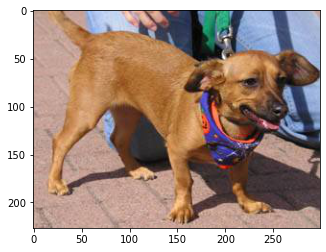

In [46]:
predict_image(r'C:\Users\Sahil\DS ML tests\Project Cats vs Dogs\dogs_cats_sample_1000\valid\dogs\dog.73.jpg')

1/1 [==============================] - 0s 97ms/step
Cat


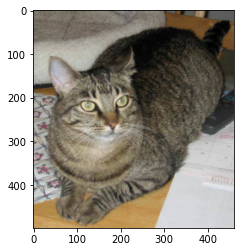

In [47]:
predict_image(r'C:\Users\Sahil\DS ML tests\Project Cats vs Dogs\dogs_cats_sample_1000\valid\cats\cat.415.jpg')